In [ ]:
import numpy as np
from scipy.special import erf
import os
import sys
import time
import copy
import logging
import matplotlib.pyplot as plt

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_dir, 'src')
log_dir = os.path.join(project_dir, 'log')
fig_dir = os.path.join(project_dir, 'fig')

# Add the src directory to sys.path
sys.path.append(src_dir)

from analysis.commons import batch_estimator_estimated_delta, compute_bootstrap_range
from utils.constants import BATCH_SAMPLES, WORKERS
from utils.commons import convert_bytes_to_mb, convert_bytes_to_gb

from estimator.approx_least_square_mechanism import ApproximateLeastSquareEstimator, AsymptoticDistributionEstimator, ApproximateLeastSquareGenerator
from Dataset.cancer_dataset_for_LS import main_generate_cancer_matrices_for_LS, load_cancer_dataset_matrices_for_LS

from analysis.ALS_privacy_analysis import compute_analytical_asymptotic_delta_for_all_neighbors, get_matrix_Q, get_neighbor_matrix_Q
from analysis.ALS_privacy_analysis import compute_analytical_asymptotic_delta_for_epsilon_lists
from analysis.ALS_privacy_analysis import compute_analytical_asymptotic_dist_delta, compute_analytical_asymptotic_delta_for_r_lists


from analysis.commons import compute_xopt, sample_approx_xopt_error, twoNorm, multiplication_sequence_generating_function
from analysis.commons import data_normalize_by_features, data_normalize_by_sample, get_neighbors_index_list, concatenate_B_b, generate_default_configuration
from analysis.commons import get_neighbor_B, get_neighbor_b, clac_standard_vec, calc_proj_matrix

from analysis.commons import check_equal, compute_approx_xopt, compute_approx_xopt_chunk, get_w
from analysis.commons import get_neighbor_w


from numpy.linalg import inv as mat_inv
from analysis.archive_NDIS import _check_kd_asymptotic_dist_delta
from estimator.GRP import NoiseRandomProjectionEstimator, NoiseRandomProjectionGenerator

In [2]:
logfile_path = os.path.join(log_dir, 'kNN-RP-cancer-default.log')
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    handlers=[
        logging.FileHandler(logfile_path),
        # logging.StreamHandler()
    ]
)

def store_array_str(data_array):
    converted_str = np.array_str(data_array)
    converted_str = converted_str.replace(' ',',')
    return converted_str

file_X_path = os.path.join(project_dir, "Dataset", "cancer-LR-X.txt")
file_y_path = os.path.join(project_dir, "Dataset", "cancer-LR-y.txt")

X = None
y = None
try:
    X, y = load_cancer_dataset_matrices_for_LS(file_X_name=file_X_path, file_y_name=file_y_path)
except:
    main_generate_cancer_matrices_for_LS(file_X_name=file_X_path, file_y_name=file_y_path)
    X, y = load_cancer_dataset_matrices_for_LS()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

B = StandardScaler().fit_transform(X) # normalizing the features
pca_factory = PCA(n_components=2)
B = pca_factory.fit_transform(B)

B, b = data_normalize_by_features(B, y)
A = concatenate_B_b(B, b)

In [4]:
from scipy.stats import chi2
def evaluate_rp_mech(index, A, r, epsilon, sigma):
    """
    Evaluates the expression:

        δ(ε) = P(Y >= (1 - leverage)(2ε - rln(1 - leverage))/leverage)
               - exp(ε - r/2 * ln(1 - leverage)) * (1 - leverage)^(r/2)
                 * P(Y >= (2ε - rln(1 - leverage))/leverage),

    where Y is a chi-squared distributed random variable with r degrees of freedom.

    Parameters:
    leverage (float): The leverage value.
    epsilon (float): The epsilon value.
    r (int): Degrees of freedom for the chi-squared distribution.

    Returns:
    float: The evaluated expression.
    """
    v = A[index].copy().reshape(-1, 1)
    M = np.linalg.inv(A.T @ A + sigma**2*np.eye(A.shape[1]))
    leverage = (v.T@M@v).item()
    # Compute the terms inside the probabilities
    term1 = (1 - leverage) * (2 * epsilon - r * np.log(1 - leverage)) / leverage

    term2 = (2 * epsilon - r * np.log(1 - leverage)) / leverage

    # Compute each probability term
    prob1 = 1 - chi2.cdf(term1, r)
    prob2 = 1 - chi2.cdf(term2, r)

    # Compute the exponential term
    exp_term = np.exp(epsilon - r / 2 * np.log(1 - leverage)) * (1 - leverage)**(r / 2.0)

    # Combine the terms to get the result
    result = prob1 - exp_term * prob2

    return result

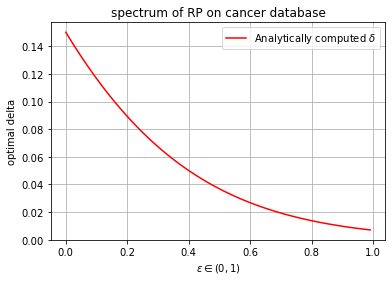

In [5]:
index = 186
epsilon_list = np.arange(0.00001, 1, 0.01)
r = 10
sigma = 1
delta_list = []

for epsilon in epsilon_list:
    delta_list.append(evaluate_rp_mech(index, A, r, epsilon, sigma))

    
plt.title(r'spectrum of RP on cancer database')
plt.xlabel(r"$\varepsilon \in (0,1)$")
plt.ylabel("optimal delta")
plt.grid()
plt.plot(epsilon_list, delta_list, color ="red", label=r"Analytically computed $\delta$")
plt.legend(loc='best')
plt.show()

In [6]:
def generate_default_configuration():
    claimed_epsilon = 0.1
    gamma = 0.01

    dataset_settings = {
        'database_0': None,
        'database_1': None,
        'claimed_epsilon': claimed_epsilon,
        'r':1
    }

    kwargs = {
        'sigma':sigma,
        'dataset_settings': dataset_settings,
        'gamma': 0.01,
        'training_set_size': 2*(10 ** 6), 'validation_set_size': 10 ** 6,
        'samples_file_pos': "/scratch/bell/wei402/preproceed-samples/RP-cancer-3-pos",
        'samples_file_neg': "/scratch/bell/wei402/preproceed-samples/RP-cancer-3-neg",
        'batch_size' : 10**6
    }
    
    return kwargs

kwargs = generate_default_configuration()

dataset_settings = {
    'database_0': get_neighbor_B(index, A).T,
    'database_1': A.T,
    'r': 10
}

kwargs['dataset_settings'] = dataset_settings

file_name = "/scratch/bell/wei402/nn-temp/DP-test-RP-5"
classifier_args = {"n_epoch": 20, "batch_size": 1000, "lr": 0.0001, "n_batches": 100, "model": None}

In [7]:
claimed_epsilon = 0
kwargs['dataset_settings']['claimed_epsilon'] = claimed_epsilon
estimator = NoiseRandomProjectionEstimator(kwargs) 

estimator.preprocess_sample(workers=60, generate_positive_sample=True)
estimator.preprocess_sample(workers=60, generate_positive_sample=False)

In [ ]:
claimed_epsilon_list = np.arange(0, 1.1, 0.1)
input_list = []
estimated_delta = []
for claimed_epsilon in claimed_epsilon_list:
    kwargs['dataset_settings']['claimed_epsilon'] = claimed_epsilon
    estimator = NoiseRandomProjectionEstimator(kwargs) 
    estimator.parallel_build_nn(file_name=file_name, workers=60, classifier_args=classifier_args, preproceed_samples=True)
    logging.critical(estimator.output_)
    estimated_delta.append(estimator.output_['estimated_delta'])
    logging.critical(store_array_str(np.array(estimated_delta)))

estimated_delta_list = np.array(estimated_delta)

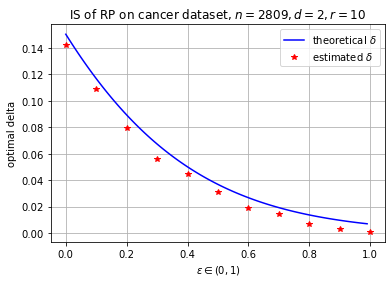

In [9]:
figfile_path = os.path.join(fig_dir, 'RP_cancer.png')

plt.title(r"IS of RP on cancer dataset, $n=2809, d=2, r=10$")
plt.xlabel(r"$\epsilon \in (0, 1)$")
plt.ylabel(r"optimal delta")
plt.grid()
plt.plot(epsilon_list, delta_list , color ="blue", label=r"theoretical $\delta$")
plt.plot(claimed_epsilon_list, estimated_delta_list, "*", color ="red", label="estimated $\delta$")
plt.legend(loc='best')
plt.savefig(figfile_path, bbox_inches = 'tight', dpi = 150);
plt.show()